<a href="https://colab.research.google.com/github/s27dsam/Gibbsland_Lake_Analysis/blob/master/Gippsland_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
# Load the dataset
file_path = '/content/1990_01-2023_06_Gippsland_Lakes_Water_quality_data.xlsx'
data = pd.read_excel(file_path)

# Calculate the percentage of missing values for each column
missing_data_percentage = data.isnull().mean() * 100

# Set a threshold for missing data to decide whether to drop the column
threshold = 50  # percentage
columns_to_drop = missing_data_percentage[missing_data_percentage > threshold].index.tolist()

# Drop columns with missing data above the threshold
data_cleaned = data.drop(columns=columns_to_drop)

# Remove any duplicate rows in the dataset
data_cleaned = data_cleaned.drop_duplicates()

# Rename columns for clarity and consistency
renamed_data = data_cleaned.rename(columns=lambda x: x.strip().replace(" ", "_").lower())


In [3]:
renamed_data.head()

,site_id,site_name_short,water_body,date,type,chl_a,do_mg,sal,temp,do_sat,tss,n_nh3,n_no2,n_no3,n_nox,n_total,p_po4,p_total,si
0,2306,Lake Wellington,Gippsland Lakes,1990-01-22,surface,NaN,NaN,3.5,22.1,NaN,NaN,4.93,0.25,0.00,0.21,574.23,1.01,32.52,1020.80
1,2306,Lake Wellington,Gippsland Lakes,1990-01-22,bottom,NaN,NaN,3.8,20.4,NaN,NaN,4.81,0.25,-0.03,0.21,580.81,4.23,34.48,1263.30
2,2311,Lake Victoria,Gippsland Lakes,1990-01-22,surface,NaN,NaN,16.8,21.5,NaN,NaN,5.97,0.14,-0.16,-0.02,526.85,10.38,41.56,62.44
3,2311,Lake Victoria,Gippsland Lakes,1990-01-22,bottom,NaN,NaN,25.2,20.4,NaN,NaN,33.02,0.32,0.25,0.57,456.93,75.95,107.53,798.39
4,2314,Lake King South,Gippsland Lakes,1990-01-22,surface,NaN,NaN,18.9,22.2,NaN,NaN,6.39,0.14,0.07,0.21,831.75,11.05,47.69,7.10


In [4]:
renamed_data['site_name_short'] = renamed_data['site_name_short'].str.replace(r'\s+', '_', regex=True)

# Verify the change
renamed_data['site_name_short'].unique()

array(['Lake_Wellington', 'Lake_Victoria', 'Lake_King_South',
       'Lake_King_North', 'Shaving_Point', 'Lake_Reeve_East',
       'Lake_Reeve_West'], dtype=object)

In [5]:
# Isolate the columns for salinity and dissolved oxygen along with 'date' and 'site_name_short'
water_quality_data = renamed_data[['sal', 'do_mg', 'date', 'site_name_short']]

# Drop rows where 'sal' or 'do_mg' are missing
water_quality_comparison_data = water_quality_data.dropna(subset=['sal', 'do_mg'])

In [6]:
water_quality_comparison_data.head()

,sal,do_mg,date,site_name_short
76,5.8192,7.3,1991-02-21,Lake_Wellington
77,5.7526,8.5,1991-02-21,Lake_Wellington
78,25.9620,5.8,1991-02-21,Lake_Victoria
79,33.7860,2.9,1991-02-21,Lake_Victoria
80,28.8620,4.6,1991-02-21,Lake_King_South


In [7]:
water_quality_comparison_data = water_quality_comparison_data[water_quality_comparison_data['site_name_short'] != 'Lake_Reeve_East']
# drop Lake_Reeve_East as its only has data from the last few years

In [8]:
water_quality_comparison_data['site_name_short'].unique()

array(['Lake_Wellington', 'Lake_Victoria', 'Lake_King_South',
       'Lake_King_North', 'Shaving_Point'], dtype=object)

In [9]:
water_quality_trends = water_quality_comparison_data.groupby(['site_name_short', 'date']).mean().reset_index()

In [10]:
water_quality_trends.head()

,site_name_short,date,sal,do_mg
0,Lake_King_North,1991-02-21,28.2990,5.15
1,Lake_King_North,1991-04-11,27.0495,7.15
2,Lake_King_North,1991-05-15,24.8500,9.80
3,Lake_King_North,1991-06-19,25.0870,9.25
4,Lake_King_North,1991-09-03,13.3765,12.15


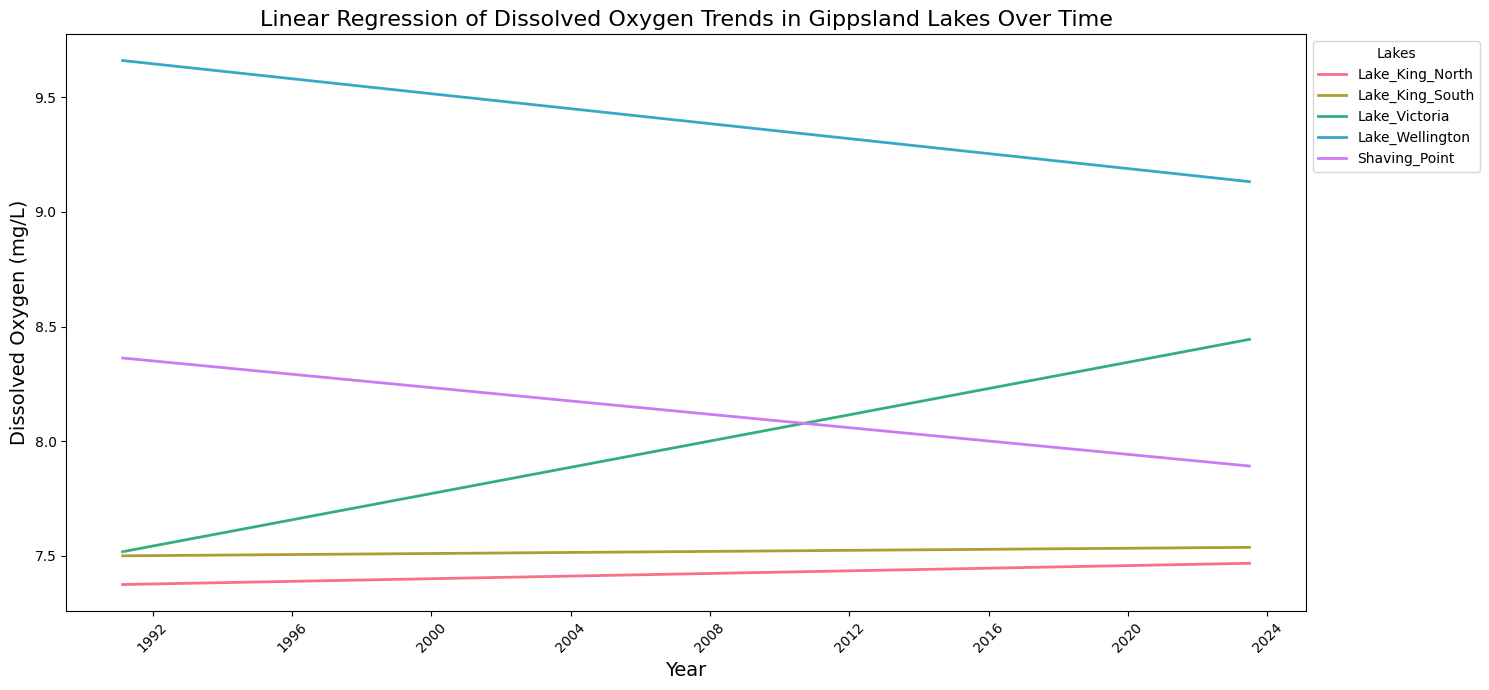

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import linregress
import seaborn as sns  # For a nice palette of colors

# Assuming 'water_quality_trends' is your DataFrame and it's properly preprocessed
# Create a figure and a set of subplots for dissolved oxygen
fig, ax = plt.subplots(figsize=(15, 7))

# Define a color palette
palette = sns.color_palette('husl', n_colors=water_quality_trends['site_name_short'].nunique())

# Plot the regression line for dissolved oxygen data for each lake
for idx, (lake, color) in enumerate(zip(water_quality_trends['site_name_short'].unique(), palette)):
    # Select data for the current lake
    lake_data = water_quality_trends[water_quality_trends['site_name_short'] == lake].copy()

    # Convert dates to ordinal numbers for regression and store them in the 'date_ordinal' column
    lake_data['date_ordinal'] = pd.to_datetime(lake_data['date']).apply(lambda x: x.toordinal())




    # Calculate the linear regression
    slope, intercept, r_value, p_value, std_err = linregress(lake_data['date_ordinal'], lake_data['do_mg'])

    # Create the regression line
    reg_line = slope * lake_data['date_ordinal'] + intercept

    # Plot the regression line with a unique color and label
    ax.plot(lake_data['date'], reg_line, label=lake, color=color, linewidth=2)

# Title and labels for dissolved oxygen plot
ax.set_title('Linear Regression of Dissolved Oxygen Trends in Gippsland Lakes Over Time', fontsize=16)
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Dissolved Oxygen (mg/L)', fontsize=14)

# Legend
ax.legend(title='Lakes', loc='upper left', bbox_to_anchor=(1, 1))

# Formatting the date ticks
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

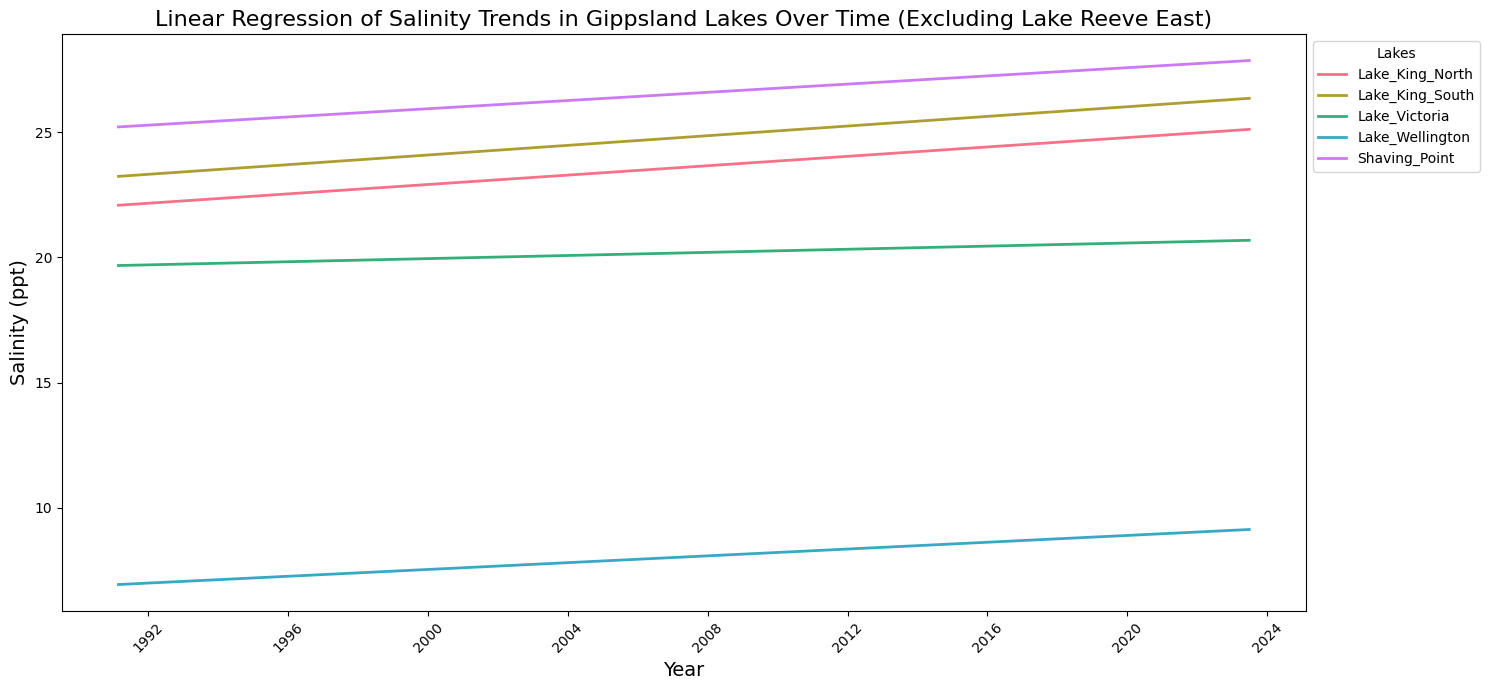

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import linregress
import seaborn as sns  # For a nice palette of colors

# Assuming 'water_quality_trends' is your DataFrame and it's properly preprocessed
# Create a figure and a set of subplots for dissolved oxygen
fig, ax = plt.subplots(figsize=(15, 7))

# Define a color palette
palette = sns.color_palette('husl', n_colors=water_quality_trends['site_name_short'].nunique())

# Plot the regression line for dissolved oxygen data for each lake
for idx, (lake, color) in enumerate(zip(water_quality_trends['site_name_short'].unique(), palette)):
    # Select data for the current lake
    lake_data = water_quality_trends[water_quality_trends['site_name_short'] == lake].copy()

    # Convert dates to ordinal numbers for regression and store them in the 'date_ordinal' column
    lake_data['date_ordinal'] = pd.to_datetime(lake_data['date']).apply(lambda x: x.toordinal())



    # Calculate the linear regression
    slope, intercept, r_value, p_value, std_err = linregress(lake_data['date_ordinal'], lake_data['sal'])

    # Create the regression line
    reg_line = slope * lake_data['date_ordinal'] + intercept

    # Plot the regression line with a unique color and label
    ax.plot(lake_data['date'], reg_line, label=lake, color=color, linewidth=2)

# Title and labels for dissolved oxygen plot
ax.set_title('Linear Regression of Salinity Trends in Gippsland Lakes Over Time (Excluding Lake Reeve East)', fontsize=16)
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Salinity (ppt)', fontsize=14)

# Legend
ax.legend(title='Lakes', loc='upper left', bbox_to_anchor=(1, 1))

# Formatting the date ticks
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [13]:
import pandas as pd
from scipy.stats import linregress

# Assuming 'water_quality_trends' is your DataFrame with the relevant data
# Ensure 'date' is in datetime format and 'sal' contains salinity measurements

# First, ensure the 'date' column is in datetime format
water_quality_trends['date'] = pd.to_datetime(water_quality_trends['date'])

# Prepare a dictionary to store the percentage increase for each lake
percentage_increase = {}

# Loop through each unique lake in your dataset
for lake in water_quality_trends['site_name_short'].unique():

    # Filter the data for the current lake
    lake_data = water_quality_trends[water_quality_trends['site_name_short'] == lake]

    # Sort the data by date to ensure correct calculation
    lake_data = lake_data.sort_values(by='date')

    # Filter out data to keep only the last 30 years
    ten_years_ago = lake_data['date'].max() - pd.DateOffset(years=30)
    lake_data = lake_data[lake_data['date'] >= ten_years_ago]

    # Check if there is enough data to calculate the percentage increase
    if len(lake_data) > 1:
        # Calculate the initial and final salinity values
        initial_salinity = lake_data.iloc[0]['sal']
        final_salinity = lake_data.iloc[-1]['sal']

        # Calculate the percentage increase
        increase = (final_salinity - initial_salinity) / initial_salinity * 100
        percentage_increase[lake] = increase

# Print or return the percentage increases
print(percentage_increase)

{'Lake_King_North': 11.276378984136242, 'Lake_King_South': 4.234947940244462, 'Lake_Victoria': 16.20882971268397, 'Lake_Wellington': 21.954444668413633, 'Shaving_Point': 5.023077937491744}


In [79]:
for lake in water_quality_trends['site_name_short'].unique():

    # Filter the data for the current lake
    lake_data = water_quality_trends[water_quality_trends['site_name_short'] == lake]

    # Sort the data by date to ensure correct calculation
    lake_data = lake_data.sort_values(by='date')

    # Filter out data to keep only the last 10 years
    ten_years_ago = lake_data['date'].max() - pd.DateOffset(years=30)
    lake_data = lake_data[lake_data['date'] >= ten_years_ago]

    # Check if there is enough data to calculate the percentage increase
    if len(lake_data) > 1:
        # Calculate the initial and final salinity values
        initial_salinity = lake_data.iloc[0]['sal']
        final_salinity = lake_data.iloc[-1]['sal']
    print(final_salinity)

26.7603
27.6306
20.72875
7.5627
27.873649999999998


In [14]:
import pandas as pd
from scipy.stats import linregress

# First, ensure the 'date' column is in datetime format
water_quality_trends['date'] = pd.to_datetime(water_quality_trends['date'])

# Prepare a dictionary to store the percentage increase for each lake
percentage_increase = {}

# Loop through each unique lake in your dataset
for lake in water_quality_trends['site_name_short'].unique():

    # Filter the data for the current lake
    lake_data = water_quality_trends[water_quality_trends['site_name_short'] == lake]

    # Sort the data by date to ensure correct calculation
    lake_data = lake_data.sort_values(by='date')

    # Filter out data to keep only the last 10 years
    ten_years_ago = lake_data['date'].max() - pd.DateOffset(years=30)
    lake_data = lake_data[lake_data['date'] >= ten_years_ago]

    # Check if there is enough data to calculate the percentage increase
    if len(lake_data) > 1:
        # Calculate the initial and final salinity values
        initial_salinity = lake_data.iloc[0]['do_mg']
        final_salinity = lake_data.iloc[-1]['do_mg']

        # Calculate the percentage increase
        increase = (final_salinity - initial_salinity) / initial_salinity * 100
        percentage_increase[lake] = increase

# Print or return the percentage increases
print(percentage_increase)

{'Lake_King_North': 27.249340369393117, 'Lake_King_South': 4.011461318051572, 'Lake_Victoria': -1.780957079427729, 'Lake_Wellington': -5.939694341181339, 'Shaving_Point': 14.149746192893414}


In [80]:
for lake in water_quality_trends['site_name_short'].unique():

    # Filter the data for the current lake
    lake_data = water_quality_trends[water_quality_trends['site_name_short'] == lake]

    # Sort the data by date to ensure correct calculation
    lake_data = lake_data.sort_values(by='date')

    # Filter out data to keep only the last 10 years
    ten_years_ago = lake_data['date'].max() - pd.DateOffset(years=30)
    lake_data = lake_data[lake_data['date'] >= ten_years_ago]

    # Check if there is enough data to calculate the percentage increase
    if len(lake_data) > 1:
        # Calculate the initial and final salinity values
        initial_salinity = lake_data.iloc[0]['do_mg']
        final_salinity = lake_data.iloc[-1]['do_mg']
    print(final_salinity)

9.645499999999998
9.075
9.9545
11.386
8.995000000000001


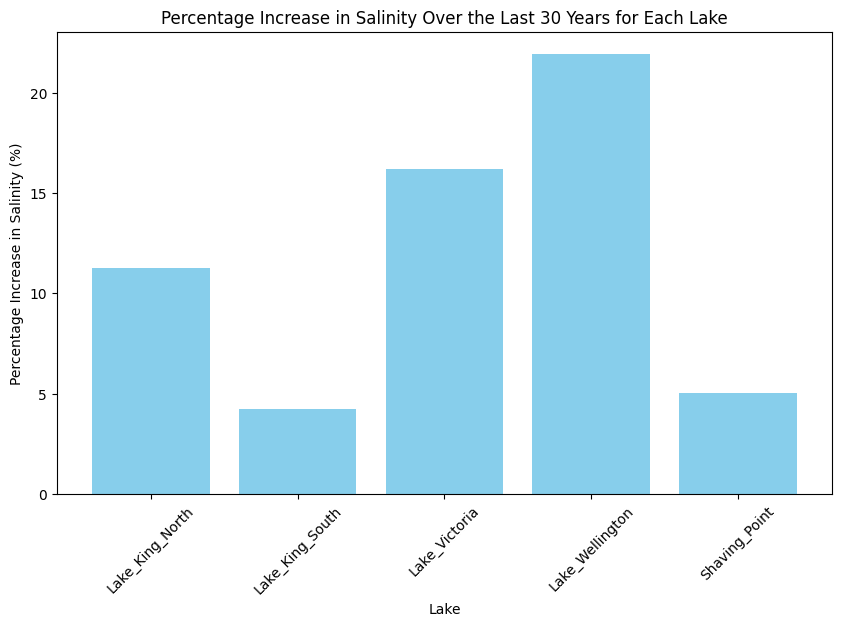

In [16]:
# Adjusting the code to calculate the percentage increase over the last 30 years for each lake

# Convert 'date' column to datetime format
water_quality_trends['date'] = pd.to_datetime(water_quality_trends['date'])

# Prepare a dictionary to store the percentage increase for each lake
percentage_increase = {}

# Loop through each unique lake in the dataset
for lake in water_quality_trends['site_name_short'].unique():
    # Filter the data for the current lake
    lake_data = water_quality_trends[water_quality_trends['site_name_short'] == lake]

    # Sort the data by date to ensure correct calculation
    lake_data = lake_data.sort_values(by='date')

    # Filter out data to keep only the last 30 years
    thirty_years_ago = lake_data['date'].max() - pd.DateOffset(years=30)
    lake_data = lake_data[lake_data['date'] >= thirty_years_ago]

    # Check if there is enough data to calculate the percentage increase
    if len(lake_data) > 1:
        # Calculate the initial and final salinity values
        initial_salinity = lake_data.iloc[0]['sal']
        final_salinity = lake_data.iloc[-1]['sal']

        # Calculate the percentage increase
        increase = (final_salinity - initial_salinity) / initial_salinity * 100
        percentage_increase[lake] = increase

# Now, let's plot the results
plt.figure(figsize=(10, 6))
plt.bar(percentage_increase.keys(), percentage_increase.values(), color='skyblue')
plt.xlabel('Lake')
plt.ylabel('Percentage Increase in Salinity (%)')
plt.title('Percentage Increase in Salinity Over the Last 30 Years for Each Lake')
plt.xticks(rotation=45)  # Rotate x-labels for better readability
plt.show()


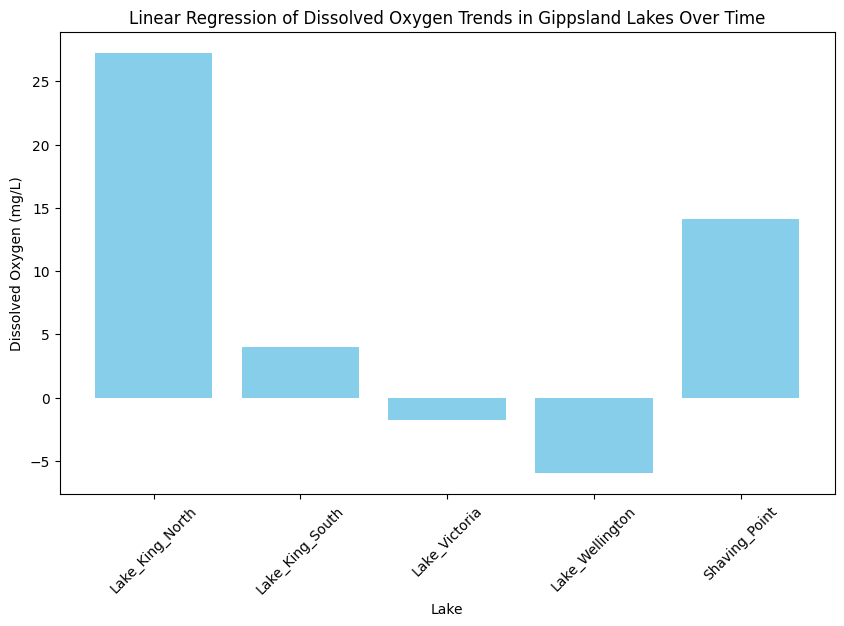

In [17]:
# Convert 'date' column to datetime format
water_quality_trends['date'] = pd.to_datetime(water_quality_trends['date'])

# Prepare a dictionary to store the percentage increase for each lake
percentage_increase = {}

# Loop through each unique lake in the dataset
for lake in water_quality_trends['site_name_short'].unique():
    # Filter the data for the current lake
    lake_data = water_quality_trends[water_quality_trends['site_name_short'] == lake]

    # Sort the data by date to ensure correct calculation
    lake_data = lake_data.sort_values(by='date')

    # Filter out data to keep only the last 30 years
    thirty_years_ago = lake_data['date'].max() - pd.DateOffset(years=30)
    lake_data = lake_data[lake_data['date'] >= thirty_years_ago]

    # Check if there is enough data to calculate the percentage increase
    if len(lake_data) > 1:
        # Calculate the initial and final salinity values
        initial_salinity = lake_data.iloc[0]['do_mg']
        final_salinity = lake_data.iloc[-1]['do_mg']

        # Calculate the percentage increase
        increase = (final_salinity - initial_salinity) / initial_salinity * 100
        percentage_increase[lake] = increase

# Now, let's plot the results
plt.figure(figsize=(10, 6))
plt.bar(percentage_increase.keys(), percentage_increase.values(), color='skyblue')
plt.xlabel('Lake')
plt.ylabel('Dissolved Oxygen (mg/L)')
plt.title('Linear Regression of Dissolved Oxygen Trends in Gippsland Lakes Over Time')
plt.xticks(rotation=45)  # Rotate x-labels for better readability
plt.show()

In [32]:
water_quality_trends.head()

,site_name_short,date,sal,do_mg
0,Lake_King_North,1991-02-21,28.2990,5.15
1,Lake_King_North,1991-04-11,27.0495,7.15
2,Lake_King_North,1991-05-15,24.8500,9.80
3,Lake_King_North,1991-06-19,25.0870,9.25
4,Lake_King_North,1991-09-03,13.3765,12.15


In [35]:
water_quality_trends['site_name_short'].unique()

array(['Lake_King_North', 'Lake_King_South', 'Lake_Victoria',
       'Lake_Wellington', 'Shaving_Point'], dtype=object)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error

# Assuming your data is loaded into a DataFrame named water_quality_trends
# Filter data for Lake King North and preprocess
lake_king_north = water_quality_trends[water_quality_trends['site_name_short'] == 'Lake_King_North']
lake_king_north['date'] = pd.to_datetime(lake_king_north['date'])
lake_king_north.sort_values('date', inplace=True)

# Resampling to monthly intervals and filling missing values
monthly_data = lake_king_north.resample('M', on='date').mean()
monthly_data['sal'].fillna(method='ffill', inplace=True)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(monthly_data[['sal']])

# Create dataset for LSTM 60 = look back 5 years
def create_dataset(data, look_back=60):
    X, Y = [], []
    for i in range(len(data) - look_back):
        a = data[i:(i + look_back), 0]
        X.append(a)
        Y.append(data[i + look_back, 0])
    return np.array(X), np.array(Y)

X, y = create_dataset(scaled_data, look_back=60)

# Splitting the dataset into training and testing sets
train_size = int(len(X) * 0.95)
X_train, X_test = X[0:train_size], X[train_size:len(X)]
y_train, y_test = y[0:train_size], y[train_size:len(y)]

# Reshape input to [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],

1))

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(60, 1)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model on the training set
model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1)

# Evaluate the model on the test set
y_pred = model.predict(X_test)
test_mse = mean_squared_error(y_test, y_pred)
print('Test MSE:', test_mse)




Test MAE: 0.11903044490319256
Test RMSE: 0.16688289893900746


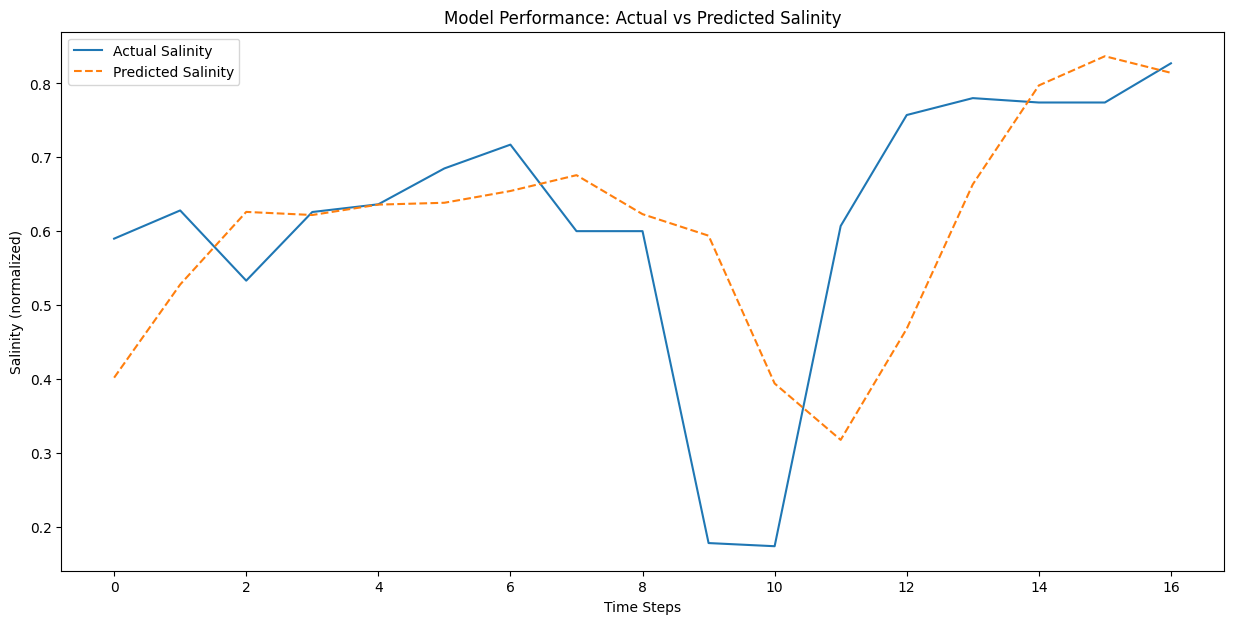

In [75]:
from sklearn.metrics import mean_absolute_error
from math import sqrt

# Assuming y_test and y_pred are already defined from your previous code

# Calculate Mean Absolute Error (MAE)
test_mae = mean_absolute_error(y_test, y_pred)
print('Test MAE:', test_mae)

# Calculate Root Mean Squared Error (RMSE)
test_rmse = sqrt(mean_squared_error(y_test, y_pred))
print('Test RMSE:', test_rmse)

# Plot the predictions against the actual values
plt.figure(figsize=(15, 7))
plt.plot(y_test, label='Actual Salinity')
plt.plot(y_pred, label='Predicted Salinity', linestyle='--')
plt.legend()
plt.xlabel('Time Steps')
plt.ylabel('Salinity (normalized)')
plt.title('Model Performance: Actual vs Predicted Salinity')
plt.show()

# Error analysis
errors = y_test - y_pred.flatten()  # Flatten in case y_pred is 2D
error_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred.flatten(), 'Error': errors})




          Actual  Predicted      Error
count  17.000000  17.000000  17.000000
mean    0.616996   0.605429   0.011567
std     0.185828   0.146123   0.171605
min     0.173899   0.317762  -0.415852
25%     0.600171   0.527974  -0.062610
50%     0.628187   0.626205   0.004055
75%     0.757282   0.663468   0.100213
max     0.827246   0.836833   0.289412


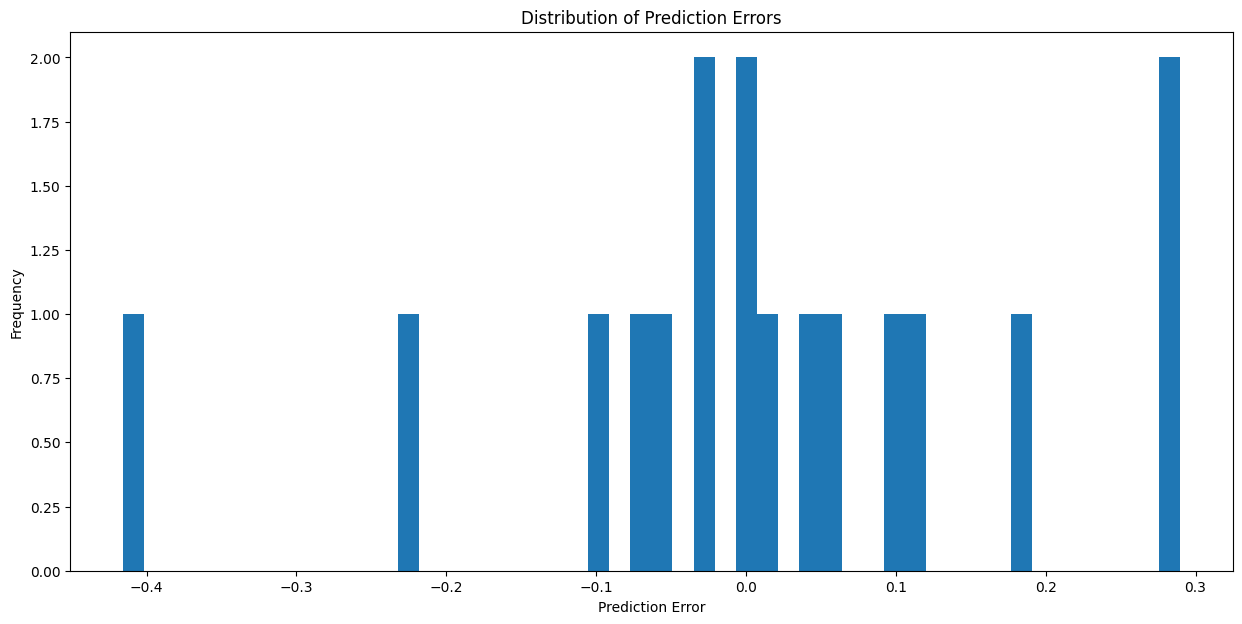

In [76]:
# Display some of the error statistics
print(error_df.describe())

# You can also plot the distribution of errors
plt.figure(figsize=(15, 7))
plt.hist(errors, bins=50)
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')
plt.show()

In [71]:
# Continue from your code:

# Make future predictions
# Let's say you have monthly data and want to predict 2 years ahead, which is 24 steps
future_steps = 60
last_known_data = scaled_data[-60:]  # last 60 months of known data
new_predictions = []
current_batch = last_known_data.reshape((1, 60, 1))

for i in range(future_steps):
    # Get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]

    # Append the prediction into the array
    new_predictions.append(current_pred)

    # Use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

# Invert predictions back to original scale
new_predictions = scaler.inverse_transform(np.array(new_predictions).reshape(-1, 1))

# Generate new dates for the predictions
last_date = monthly_data.index[-1]
new_dates = pd.date_range(start=last_date, periods=future_steps + 1, closed='right', freq='M')

# Create a new DataFrame for the predicted values
predictions_df = pd.DataFrame(new_predictions, index=new_dates, columns=['sal'])

# Combine with the original data
combined_data = pd.concat([monthly_data, predictions_df], axis=0)




1/1 [==============================] - 0s 25ms/step


<ipython-input-71-b2a3d11b4964>:25: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  new_dates = pd.date_range(start=last_date, periods=future_steps + 1, closed='right', freq='M')


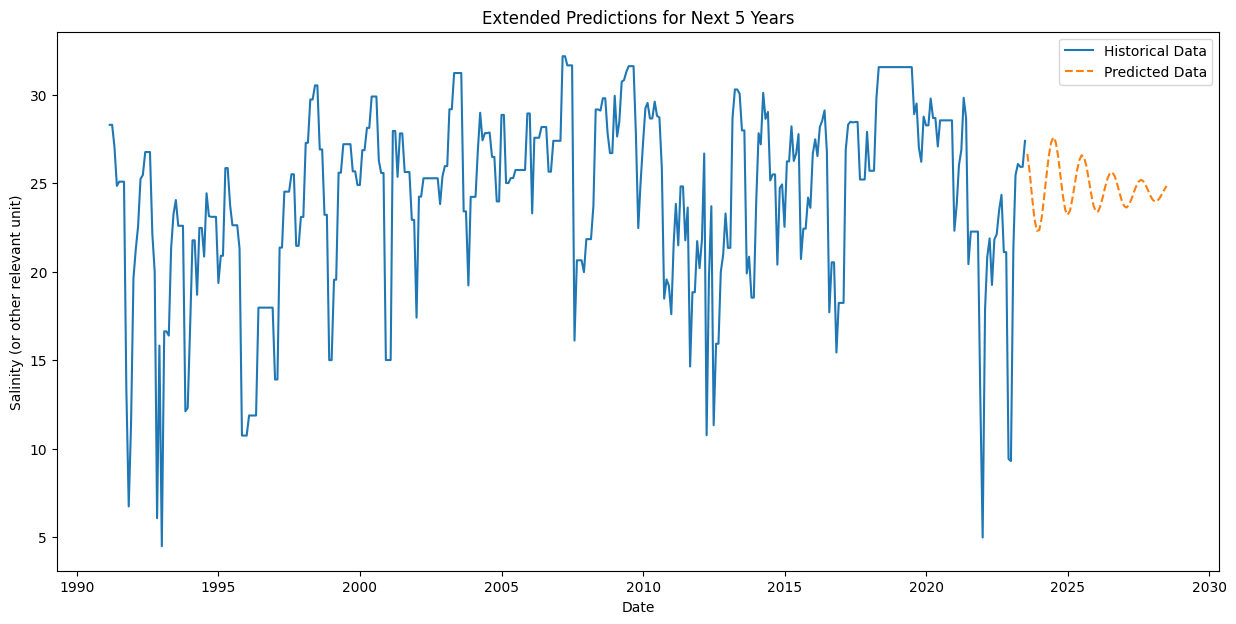

In [72]:
# Plot the results
plt.figure(figsize=(15, 7))
plt.plot(monthly_data.index, monthly_data['sal'], label='Historical Data')
plt.plot(predictions_df.index, predictions_df['sal'], label='Predicted Data', linestyle='--')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Salinity (or other relevant unit)')
plt.title('Extended Predictions for Next 5 Years')
plt.show()

In [73]:
# Assuming the previous code for generating predictions has been executed
# Display the predicted values with the corresponding dates
predictions_with_dates = pd.DataFrame({
    'Date': predictions_df.index,
    'Predicted Salinity': predictions_df['sal'].values.flatten()  # flatten in case it's a 2D array
})

# Print the predictions along with dates
print(predictions_with_dates)


         Date  Predicted Salinity
0  2023-07-31           26.652985
1  2023-08-31           25.572205
2  2023-09-30           24.197647
3  2023-10-31           22.979958
4  2023-11-30           22.308590
5  2023-12-31           22.346333
6  2024-01-31           23.013979
7  2024-02-29           24.094946
8  2024-03-31           25.331758
9  2024-04-30           26.470545
10 2024-05-31           27.283270
11 2024-06-30           27.595686
12 2024-07-31           27.326817
13 2024-08-31           26.530094
14 2024-09-30           25.412308
15 2024-10-31           24.294106
16 2024-11-30           23.496445
17 2024-12-31           23.209784
18 2025-01-31           23.441488
19 2025-02-28           24.060925
20 2025-03-31           24.875074
21 2025-04-30           25.681297
22 2025-05-31           26.296780
23 2025-06-30           26.581825
24 2025-07-31           26.465342
25 2025-08-31           25.968529
26 2025-09-30           25.213526
27 2025-10-31           24.399870
28 2025-11-30 